In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")   

sklearn version:  0.24.2
TF version:  2.6.2
No GPU was detected. CNNs can be very slow without a GPU.
GPU installed:  True


In [2]:
import tensorflow as tf
from tensorflow import keras

In [4]:
# file이 있는 path로 이동
os.chdir("./emnist")
# os.chdir('/content/drive/MyDrive/ANN/') 

In [6]:
# Load EMNIST dataset
import pandas as pd
# import gzip

byclass_train = pd.read_csv("./emnist-byclass-train.csv")
byclass_test = pd.read_csv("./emnist-byclass-test.csv")
mapp = pd.read_csv("./emnist-byclass-mapping.txt", 
                   delimiter = ' ', index_col=0, header=None, squeeze=True)

In [7]:
# DataFrame
byclass_train.shape

(697931, 785)

In [8]:
byclass_train.head()

,35,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.466,0.467,0.468,0.469,0.470,0.471,0.472,0.473,0.474,0.475
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
byclass_test.shape

(116322, 785)

In [10]:
byclass_test.head()

,18,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.652,0.653,0.654,0.655,0.656,0.657,0.658,0.659,0.660,0.661
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
classes = len(byclass_train['35'].value_counts())
print('number of classes: ', classes)

number of classes:  62


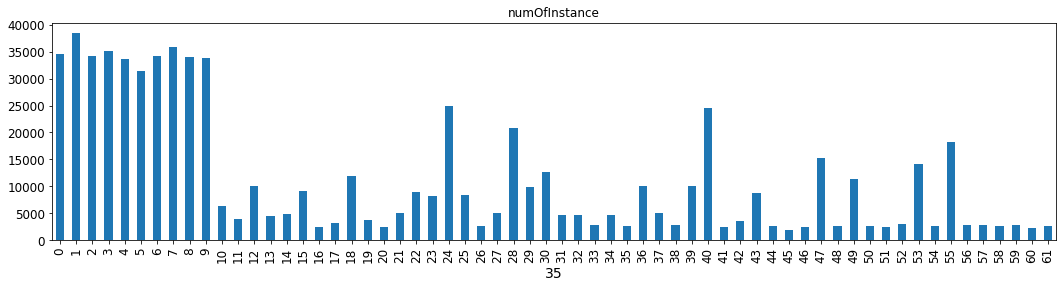

In [12]:
(byclass_train.groupby(['35']).size()).plot(kind='bar', figsize=(18, 4))
plt.title('numOfInstance')
plt.show()

In [13]:
# label만 뽑아내기
y_train_full = byclass_train[['35']]

# data만 뽑아내기
X_train_full = byclass_train.drop(['35'], axis=1)

In [14]:
# test에 대해서 반복
y_test = byclass_test[['18']]
X_test = byclass_test.drop(['18'], axis=1)

In [15]:
# pandas DF를 numpy로 바꿔주기
X_train_full, y_train_full = X_train_full.to_numpy(), y_train_full.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

In [16]:
# Normalise data
X_train_full = X_train_full/255.
X_test = X_test/255.

In [17]:
X_train_full.astype('float32')
X_test.astype('float32')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# Reshape image for CNN
X_train_full = X_train_full.reshape(-1, 28, 28, 1)

X_test = X_test.reshape(-1, 28, 28, 1)

print("X_train.shape:", X_train_full.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (697931, 28, 28, 1)
X_test.shape: (116322, 28, 28, 1)


In [19]:
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical

print('number of classes: ', classes)

# One hot encoding
y_train_full = to_categorical(y_train_full, classes)
y_test = to_categorical(y_test, classes)
print("y_train: ", y_train_full.shape)
print("y_test: ", y_test.shape)

number of classes:  62
y_train:  (697931, 62)
y_test:  (116322, 62)


In [20]:
# generate train and valid dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=321)

In [21]:
# Print shape and datatype of X_rain_full

print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)

(558344, 28, 28, 1) float64
(558344, 62) float32


# Modeling

In [129]:
from keras.models import Model
from keras.layers import Input, Dense, concatenate, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dropout
from keras.layers import BatchNormalization
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [130]:
Num_class=62
#half_in_size는 입력 feature 수의 절반 모루겠어여,,,,,,,
half_in_size = int(X_train[0].size/2)
#layer_width는 filters와 같다?
layer_width = 16

In [183]:
class SpinalNet_VGG():
    def __init__(self, input_shape=None):
        super(SpinalNet_VGG, self).__init__()
        self.input_shape = input_shape
        
        self.fc_spinal_layer1 = models.Sequential([
            layers.Dropout(rate=0.5),
            layers.Dense(layer_width, input_dim=(half_in_size,)),
            layers.BatchNormalization(),
            layers.Activation('relu') 
        ])
           
        self.fc_spinal_layer2 = models.Sequential([
            layers.Dropout(rate=0.5),
            layers.Dense(layer_width, input_dim=(half_in_size+layer_width,)),
            layers.BatchNormalization(),
            layers.Activation('relu')
        ])
        
        self.fc_spinal_layer3 = models.Sequential([
            layers.Dropout(rate=0.5),
            layers.Dense(layer_width, input_dim=(half_in_size+layer_width,)),
            layers.BatchNormalization(),
            layers.Activation('relu')
        ])
            
        self.fc_spinal_layer4 = models.Sequential([
            layers.Dropout(rate=0.5),
            layers.Dense(layer_width, input_dim=(half_in_size+layer_width,)),
            layers.BatchNormalization(),
            layers.Activation('relu')
        ])
            
        self.fc_out = models.Sequential([
            layers.Dropout(rate=0.5),
            layers.Dense(Num_class, input_dim=(layer_width*4,))
        ]) 
        
    def forward(self, x) :
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(layers.concatenate([ x[:half_in_size:2*half_in_size], x1], axis=0))
        x3 = self.fc_spinal_layer3(layers.concatenate([ x[:,0:half_in_size], x2], axis=0))
        x4 = self.fc_spinal_layer4(layers.concatenate([ x[:half_in_size:2*half_in_size], x3], axis=0))
        
        x= layers.concatenate([x1,x2], axis=0)
        x= layers.concatenate([x, x3], axis=0)
        x= layers.concatenate([x, x4], axis=0)
        
        x= self.fc_out(x)
        return x
    
    def build_model(self):
        img_input = Input(shape=self.input_shape, name='img_input')
        
        
        x = Conv2D(filters = 16, kernel_size = (1,1), padding='same', strides = (1,1))(img_input)
        x = self.forward(x)
        
        # VGG_fc랑 연결
        # input_dim=512 ?
        x = layers.Dense(16, input_dim=512)(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(rate=0.5)(x)
        x = layers.Dense(16)(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(rate=0.5)(x)
        x = layers.Flatten()(x)
        prediction = Dense(62, activation='softmax')(x)
        
        return Model(inputs=img_input, outputs=prediction, name='spinalnet')


                         
#이제 이걸 VGG에 연결하면 되는데 할 줄 몰라 ヽ(*。>Д<)o゜

In [184]:
spinalnet = SpinalNet_VGG((28,28,1))

In [185]:
spinalenet_model = spinalnet.build_model()

In [186]:
spinalenet_model.summary()

Model: "spinalnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 28, 28, 16)   32          img_input[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_86 (Sl (None, 28, 28, 16)   0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
sequential_158 (Sequential)     (None, 28, 28, 16)   336         tf.__operators__.getitem_86[0][0]
__________________________________________________________________________________________

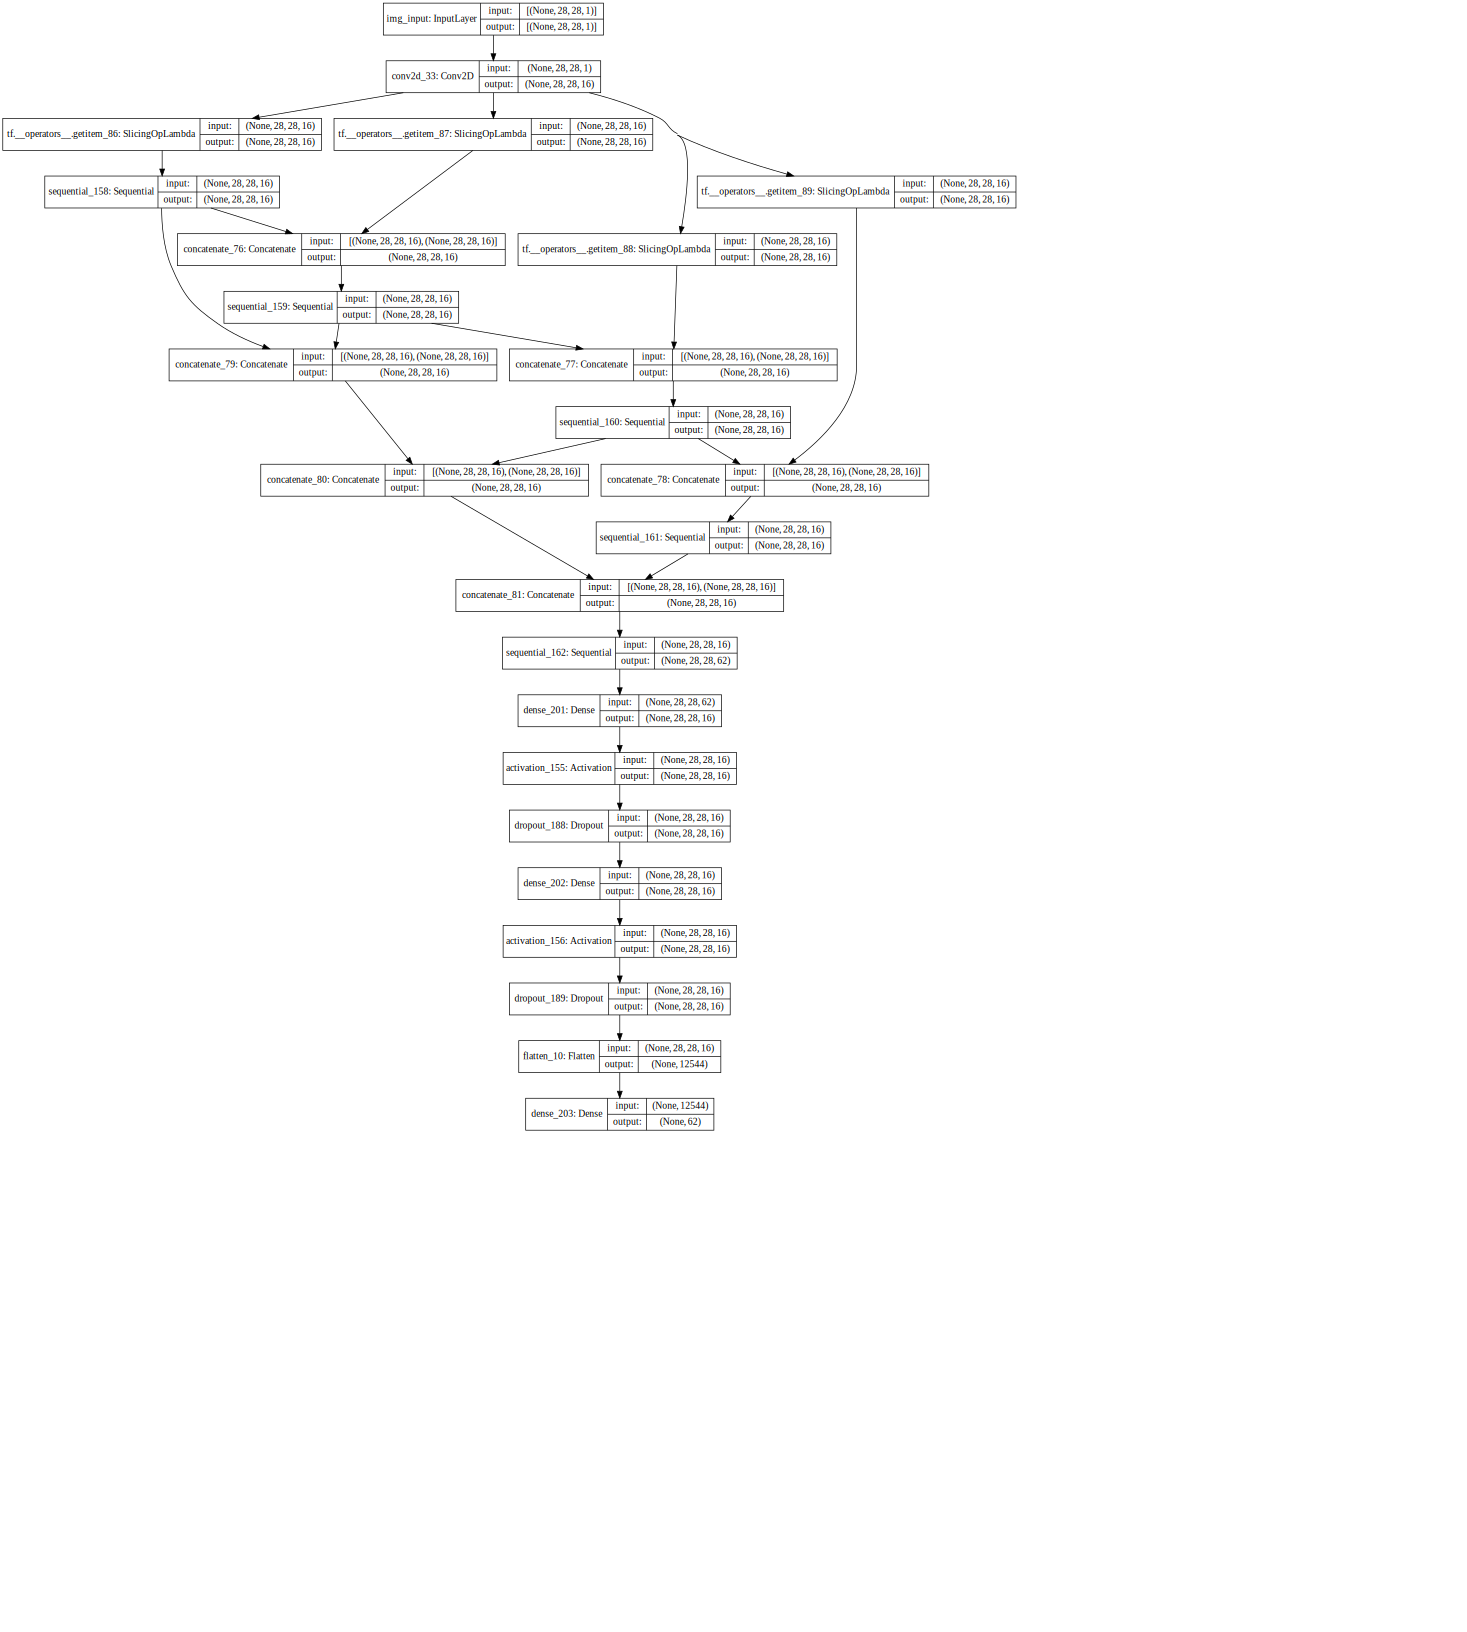

In [187]:
# pydot lib 설치 필요
import pydotplus as pydot
from tensorflow.keras.utils import plot_model

plot_model(spinalenet_model, to_file='spinalnet.png')

# visualize our model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(spinalenet_model, show_shapes=True, dpi=50).create(prog='dot', format='svg'))
# SVG(model_to_dot(inception_Model, dpi=50).create(prog='dot', format='svg'))

In [188]:
optimizer_SGD = keras.optimizers.SGD(momentum=0.9)

spinalenet_model.compile(loss='categorical_crossentropy',optimizer=optimizer_SGD, metrics=['accuracy'])

In [189]:
history_spinalnet = spinalenet_model.fit(X_train, y_train,
                                        batch_size=64,
                                        epochs=1,
                                        validation_data=(X_valid, y_valid))

InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[388,62] labels_size=[64,62]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-189-07b9c330475f>:4) ]] [Op:__inference_train_function_26761]

Function call stack:
train_function


In [ ]:
score = spinalenet_model.evaluate(X_test, y_test)
print('\nTest acc: ', score)

In [ ]:
pd.DataFrame(history_spinalnet.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()